In [1]:
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import pylab as pl
import random

In [2]:
TAM_IMAGE = 32
SCALING_LINES = 0.2
THRESHOLD = 0.5
DIFUSION_PARAMETER = 4
MINIMUM_CLUSTERS_SIZE = 15
ESTANDAR_DEVIATION = 1
d_0 = 10
theta_0 = np.pi / 6
delta = 1 / 4

In [3]:
def distance_perona(point_i, point_j):
    d_1 = -((point_j[0] - point_i[0])**2 + (point_j[1] - point_i[1])**2)/(d_0**2)
    d_2 = -(2 - np.cos(2 * point_i[2]) - np.cos(2 * point_j[2]))/(1 - np.cos(2 * theta_0))
    d_3 = -(1 - np.cos(2 * point_i[2] - 2 * point_j[2]))/(1 - np.cos(2 * delta * theta_0 ))
    return np.exp(d_1 + d_2 + d_3)

In [4]:
def distance_davide(point_i, point_j):
    q_1 = abs((point_i[0] - point_j[0])*np.cos(point_i[2]) +  (point_i[1] - point_j[1])*np.sin(point_i[2]))
    q_2 = abs(-(point_i[0] - point_j[0])*np.sin(point_i[2]) +  (point_i[1] - point_j[1])*np.cos(point_i[2]))
    p_1 = abs((point_j[0] - point_i[0])*np.cos(point_j[2]) +  (point_j[1] - point_i[1])*np.sin(point_j[2]))
    p_2 = abs(-(point_j[0] - point_i[0])*np.sin(point_j[2]) +  (point_j[1] - point_i[1])*np.cos(point_j[2]))
    distance = (np.sqrt((p_1**2) + (1 - abs(np.cos(point_i[2] - point_j[2]))) + p_2) + np.sqrt((q_1**2) + (1 - abs(np.cos(point_i[2] - point_j[2]))) + q_2))/2
    return np.exp((-distance**2)/(2*ESTANDAR_DEVIATION**2))


In [5]:
def affinity_matrix(points, distance):
    A = []
    for point_i in points:
        array = []
        for point_j in points:
            array.append(distance(point_i, point_j))
        A.append(array.copy())
    return np.asmatrix(A)

In [6]:
def degree_matrix(affinity_matrix):
    length = len(affinity_matrix)
    D = np.zeros((length, length))
    for x in range(length):
        sum = 0
        for y in range(length):
            sum += affinity_matrix[x,y]
        D[x][x] = sum
    return np.asmatrix(D)

In [7]:
def random_points(prob_elim):
    points = []
    for x in range(TAM_IMAGE):
        for y in range(TAM_IMAGE):
            if(np.random.random() < prob_elim):
                continue
            else:
                points.append([x, y, np.random.random() * 2 * np.pi])
    return points

In [8]:
def random_points_with_diagonal(prob_elim):
    points = random_points(prob_elim)
    points = [point for point in points if point[0] != point[1]]
    for i in range(TAM_IMAGE):
        points.append([i, i, np.pi / 4])
    return points

In [9]:
def random_points_with_circle(prob_elim):
    points = random_points(prob_elim)
    center = [round(TAM_IMAGE/2), round(TAM_IMAGE/2)]
    radius = 5
    num_points_circle = round(2 * np.pi * radius)
    
    for i in range(num_points_circle):
        x = round(center[0] + radius * np.cos(2 * np.pi * i / num_points_circle))
        y = round(center[1] + radius * np.sin(2 * np.pi * i / num_points_circle))
        points = [point for point in points if not(point[0] == x and point[1] == y)]
        if(x-center[0] == 0):
            theta = 0
        else:
            theta = np.arctan((y-center[1])/(x-center[0])) + np.pi/2
        points.append([x, y, theta])
    return points

In [16]:
def spectral_clustering(points, distance):
    # Paso 1
    A = affinity_matrix(points, distance)
    
    # Paso 2
    D = degree_matrix(A)
    Lrw = np.matmul(np.linalg.inv(D), A)

    # Paso 3
    vals, vects = np.linalg.eig(Lrw)
    vects = vects.transpose()
    eig = [vals, vects]

    #Ordenamos los autovectores de manera decreciente:
    indices = list(range(len(eig[0])))
    indices.sort(key = eig[0].__getitem__, reverse=True)
    for i, sublist in enumerate(eig):
        eig[i] = [sublist[j] for j in indices]
        
    # Paso 5
    q = len(eig[0]) - 1
    for i in range(len(eig[0])):
        if((eig[0][i] ** DIFUSION_PARAMETER) < 1 - THRESHOLD):
            q = i - 1
            break
    
    # print('q:', q)
        
    # Paso 6
    clusters = []
    for i in range(q):
        clusters.append([])

    for i in range(len(points)):
        index_max = 0
        max = eig[1][0][0,i]
        for j in range(1,q):
            if(eig[1][j][0,i] > max):
                index_max = j
                max = eig[1][j][0,i]
        # print(index_max)
        clusters[index_max].append(indices[i])
        
        
    # Paso 7
    alone_cluster = []
    for cluster in clusters:
        if(len(cluster) < MINIMUM_CLUSTERS_SIZE):
            alone_cluster += cluster
    clusters = [cluster for cluster in clusters if len(cluster) >= MINIMUM_CLUSTERS_SIZE]
    clusters = [alone_cluster] + clusters
    return clusters

In [17]:
def print_image(points, clusters):
    lines = []
    for point in points:
        x = point[0]
        y = point[1]
        theta = point[2]
        cos = np.cos(theta)
        sen = np.sin(theta)
        lines.append([(x + SCALING_LINES * cos, y + SCALING_LINES * sen), 
                        (x - SCALING_LINES * cos, y - SCALING_LINES * sen)])
            
    colors_search = [[0,0,0,50]]
    for _ in range(len(clusters) - 1):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        w = 1
        colors_search.append([r, g, b, w])        
    
    colors = []
    for i in range(len(points)):
        ind = [i in cluster for cluster in clusters].index(True)
        colors.append(colors_search[ind])

    # We need to set the plot limits.
    fig, ax = plt.subplots()
    ax.set_xlim(0 - 0.4, TAM_IMAGE + 0.2)
    ax.set_ylim(0 - 0.4, TAM_IMAGE + 0.2)
    
    line_segments = LineCollection(lines,
                               colors=colors, linestyle='solid')
    ax.add_collection(line_segments)
    ax.set_title('Simulation segment perception')
    plt.savefig('images/plot_' + str(THRESHOLD) + "_" + str(ESTANDAR_DEVIATION) + '.png')

In [169]:
points = random_points_with_diagonal(0.9)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(0 - 0.4, TAM_IMAGE + 0.2)
ax.set_ylim(0 - 0.4, TAM_IMAGE + 0.2)

# ax.set_title('Simulation segment perception')
plt.savefig('images/plot_' + str(THRESHOLD) + "_" + str(ESTANDAR_DEVIATION) + '.png')

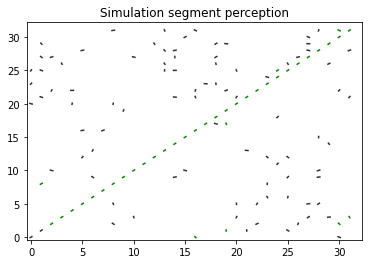

In [300]:
ESTANDAR_DEVIATION = 4.0
DIFUSION_PARAMETER = 2.0
THRESHOLD = 0.6
MINIMUM_CLUSTERS_SIZE = 22
d_0 = 9.0
theta_0 = np.pi / 5.56
delta = 1.0 / 4.0
clusters = spectral_clustering(points, distance_perona)
print_image(points, clusters)

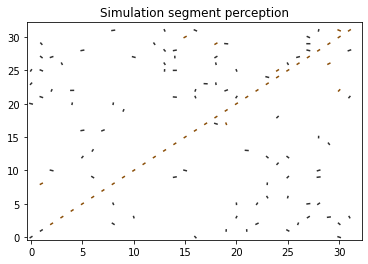

In [293]:
ESTANDAR_DEVIATION = 4.0
DIFUSION_PARAMETER = 2.0
THRESHOLD = 0.6
MINIMUM_CLUSTERS_SIZE = 22
d_0 = 8.9
theta_0 = np.pi / 5.568
delta = 1.0 / 4.0
clusters = spectral_clustering(points, distance_perona)
print_image(points, clusters)

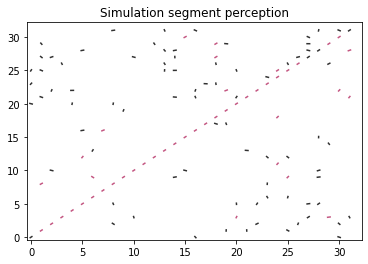

In [299]:
ESTANDAR_DEVIATION = 4.0
DIFUSION_PARAMETER = 2.0
THRESHOLD = 0.6
MINIMUM_CLUSTERS_SIZE = 32
d_0 = 8.5
theta_0 = np.pi / 5.0
delta = 1.0 / 2.0
clusters = spectral_clustering(points, distance_perona)
print_image(points, clusters)

/tmp/ipykernel_20449/351302458.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


IndexError: list index out of range

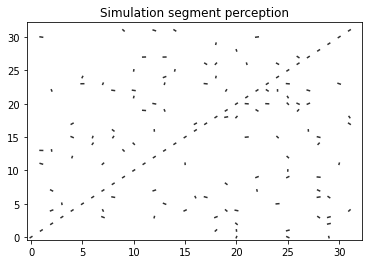

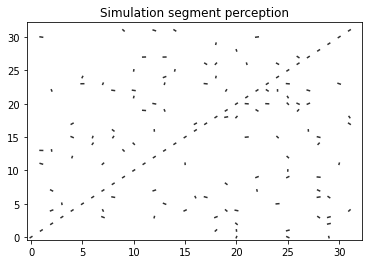

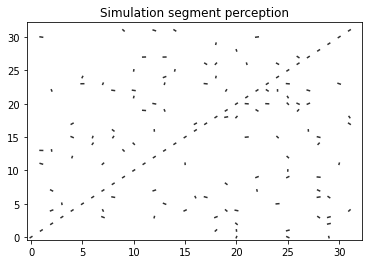

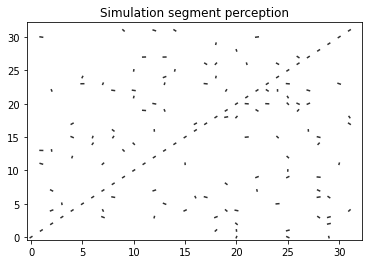

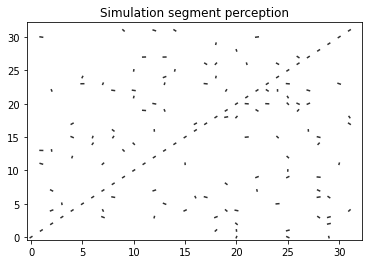

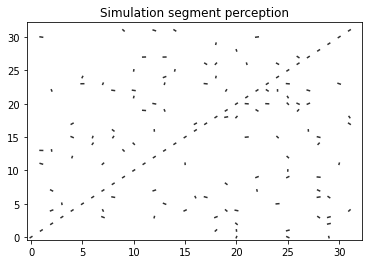

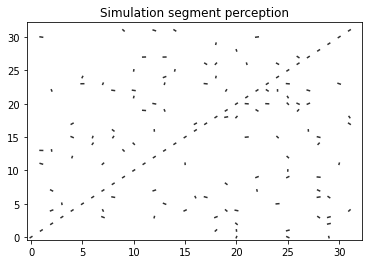

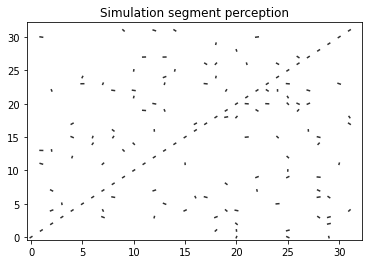

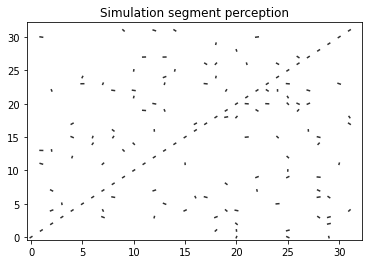

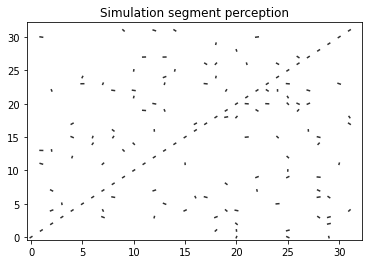

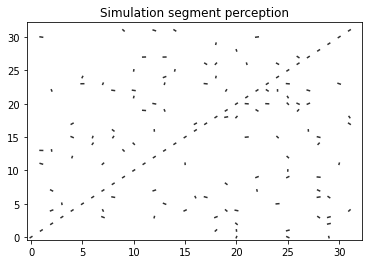

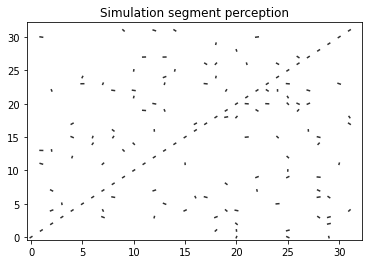

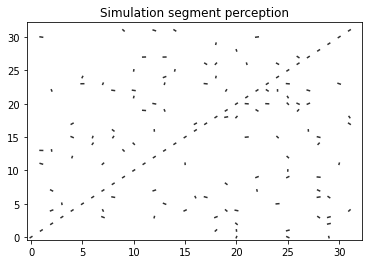

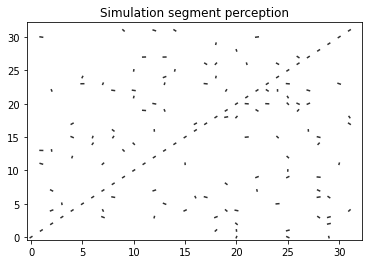

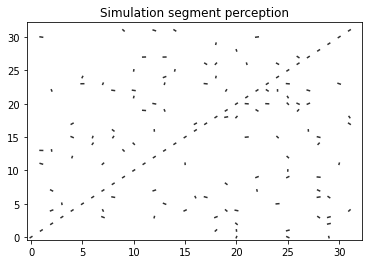

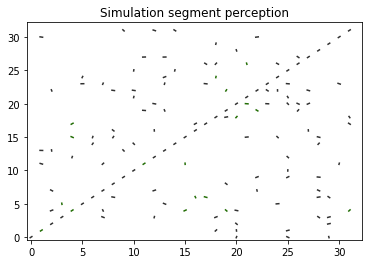

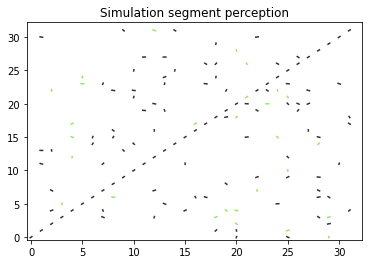

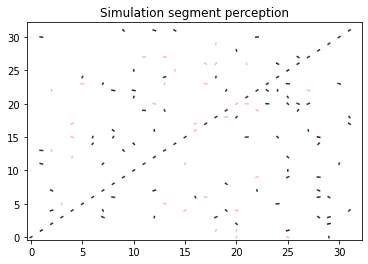

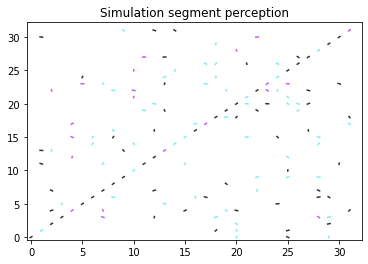

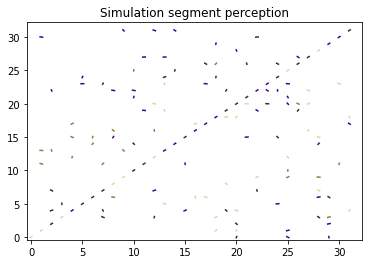

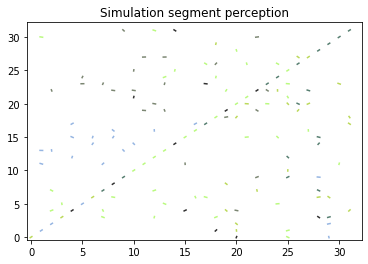

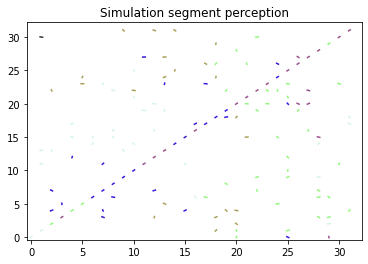

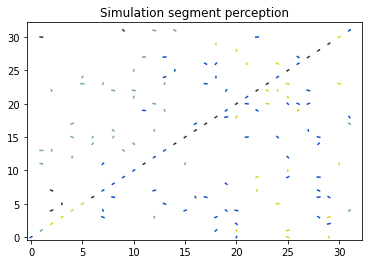

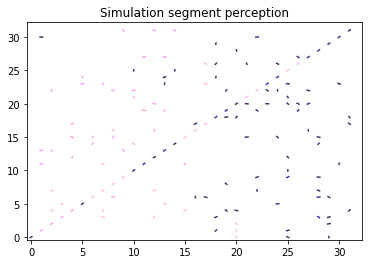

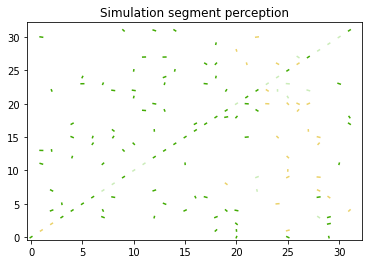

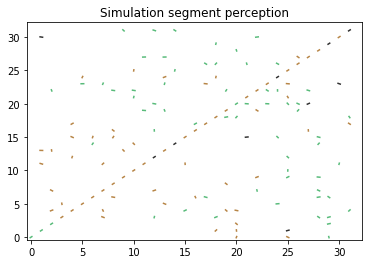

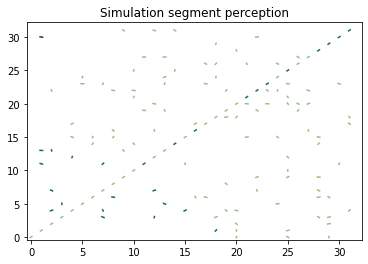

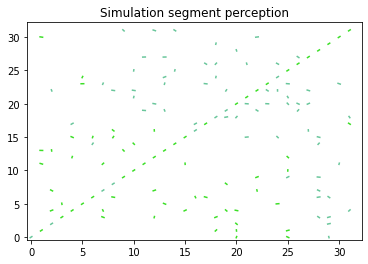

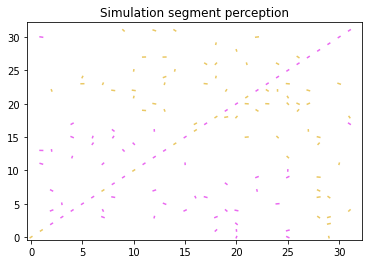

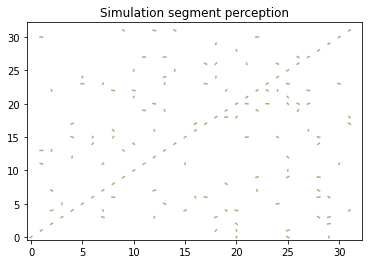

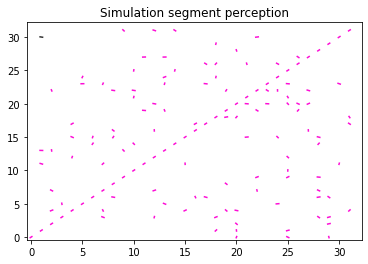

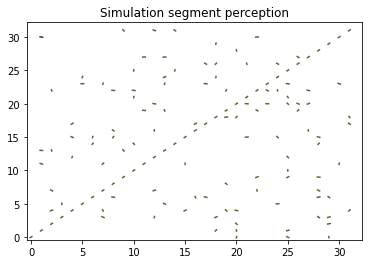

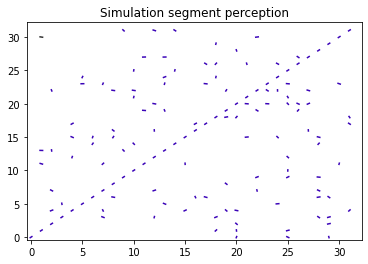

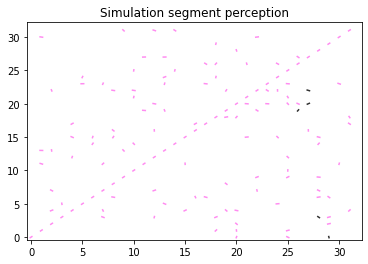

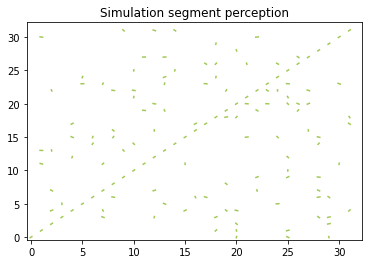

In [74]:
ESTANDAR_DEVIATION = 4.0
DIFUSION_PARAMETER = 1.5
THRESHOLD = 0.35
MINIMUM_CLUSTERS_SIZE = 18
from PIL import Image
for i in range(1, 20):
    for j in range(1, 140):
        THRESHOLD = 0.05 * i
        ESTANDAR_DEVIATION = 0.05 * j
        clusters = spectral_clustering(points, distance_davide)
        image = print_image(points, clusters)


In [ ]:
ESTANDAR_DEVIATION = 1.5
DIFUSION_PARAMETER = 2
THRESHOLD = 0.5
MINIMUM_CLUSTERS_SIZE = 18
d_0 = 6
theta_0 = np.pi / 5.5
delta = 1.0 / 4.0
points = random_points_with_circle(0.9)
clusters = spectral_clustering(points, distance_perona)
print_image(points, clusters)